In [1]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import rand_score, adjusted_rand_score
import networkx as nx
import torch
import torch.nn as nn


from preprocess import load_ts_dataset, distance_matrix, epsilon_graph_hard, epsilon_graph_mean
from nmf import nmf, nmf_sklearn, semi_nmf, sym_nmf, rgnmf_multi, kernel_nmf, sparse_nmf
from clustering_algos import kmeans, gaussian_mixture, spectral_clustering
from visualizing import plot_residuals

from deepnmf import DeepNMF, DeepNMFLoss, DANMF, DANMFLoss, deep_autoencoder_nmf, deep_nmf

c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# list of datasets
# ['Adiac', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'Car', 'CBF', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'DiatomSizeReduction', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxTW', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'GunPoint', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'InlineSkate', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxTW', 'MoteStrain', 'NonInvasiveFatalECGThorax1', 'NonInvasiveFatalECGThorax2', 'OliveOil', 'OSULeaf', 'PhalangesOutlinesCorrect', 'Phoneme', 'Plane', 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxOutlineAgeGroup', 'ProximalPhalanxTW', 'RefrigerationDevices', 'ScreenType', 'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2', 'StarLightCurves', 'Strawberry', 'SwedishLeaf', 'Symbols', 'SyntheticControl', 'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG', 'TwoPatterns', 'UWaveGestureLibraryX', 'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'UWaveGestureLibraryAll', 'Wafer', 'Wine', 'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga', 'ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PenDigits', 'PEMS-SF', 'Phoneme', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']

# used datasets
# Beef, CinCECGTorso, Coffee, DiatomSizeReduction, ECGFiveDays, MoteStrain, OliveOil, SonyAIBORobotSurface1, SonyAIBORobotSurface2, Symbols, TwoLeadECG

In [3]:
# hyperparameters for epsilon experiments

# list of methods and parameters
methods = {
    kmeans: [False], # direct
    gaussian_mixture: [False], # direct
    spectral_clustering: [False], # direct
    nmf_sklearn: [1000], # max_iter
    semi_nmf: [1000, False], # max_iters, safeguard
    sym_nmf: [1e-4, 0.1, 1000], # lr, sigma, max_iters
    #rgnmf_multi: [1e-2, 1, 1000, False, 1e-4, 1e4], # alpha, bera, max_iters, safeguard, lower_limit, higher_limit
    kernel_nmf: ['gaussian', 1.0, 3, 1.0, 1.0, 500], # kernel, sigma, degree, alpha, beta, max_iters
    sparse_nmf: [0.1, 0.1, 100], # beta, eta, max_iters
    deep_nmf: [0.01, 1000, False], # lr, nb_iters, visualize
    deep_autoencoder_nmf: [0.01, 1000, 1.0, False], # lr, nb_iters, sparsity_regularization, visualize
}

# list of datasets and parameters
hyperparameters = {
    'Beef': 50,
    #'ArrowHead': 50,
}

In [5]:
def test(methods, hyperparameters):
    # parameters for the testing
    epsilon_factor = 0.9
    
    # output dict
    output_dict = {}
    
    for dataset_name in hyperparameters.keys():
        # prepare output_dict
        output_dict[dataset_name] = {}
        
        # import dataset
        dataset = load_ts_dataset(dataset_name)
        data, true_labels = dataset[0], dataset[1]
        # build normalized distance matrix
        dist = distance_matrix(data)
        dist_n = dist / np.max(dist)

        # print number of classes of the dataset
        nb_clusters = len(np.unique(true_labels))
        print(f'Dataset has {nb_clusters} clusters !')
        
        # random partition to compare
        random_score = np.mean([rand_score(true_labels, np.random.randint(low=0, high=nb_clusters, size=len(dist))) for i in range(1000)])
        
        # test each method
        for method in methods.keys():
            print(f'Starting method {method.__name__}')
            eps = []
            residuals = []
            rands = []
            preds = []

            # start epsilon sweep
            for i in range(hyperparameters.get(dataset_name)):
                ep = epsilon_factor**i
                Anp = epsilon_graph_hard(dist_n, epsilon=ep)
                W, H, residual = method(Anp, nb_clusters, *(methods.get(method)))
                residuals.append(residual)
                eps.append(ep)
                preds.append(np.argmax(W, axis=1))
                rands.append(rand_score(true_labels, np.argmax(W, axis=1)))
            
            # find best epsilon
            idx = np.argmax(rands)

            output_dict[dataset_name][method] = {'eps': eps,
                                                'residuals': residuals,
                                                'rands': rands,
                                                'preds': preds,
                                                'best_epsilon': eps[idx],
                                                'epsilon_quantile': len(dist_n.flatten()[dist_n.flatten() <= ep]) / len(dist_n.flatten())
                                                }
    
    return output_dict



In [6]:
# sometimes kmeans raises a package error, but relaunching cell should work
output = test(methods, hyperparameters)

Dataset has 5 clusters !
Starting method kmeans


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate poi

Starting method gaussian_mixture


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(esti

Starting method spectral_clustering


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now c

Starting method nmf_sklearn


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Starting method semi_nmf


c:\Users\jbhim\_Documents JB\INFO - AllProjects\timeseries\TimeSeriesClusteringNMF\nmf.py:130: RuntimeWarning: invalid value encountered in divide
  H = H * np.sqrt((A_plus + H@B_) / (A_ + H@B_plus))
c:\Users\jbhim\_Documents JB\INFO - AllProjects\timeseries\TimeSeriesClusteringNMF\nmf.py:130: RuntimeWarning: invalid value encountered in divide
  H = H * np.sqrt((A_plus + H@B_) / (A_ + H@B_plus))
c:\Users\jbhim\_Documents JB\INFO - AllProjects\timeseries\TimeSeriesClusteringNMF\nmf.py:130: RuntimeWarning: invalid value encountered in divide
  H = H * np.sqrt((A_plus + H@B_) / (A_ + H@B_plus))
c:\Users\jbhim\_Documents JB\INFO - AllProjects\timeseries\TimeSeriesClusteringNMF\nmf.py:130: RuntimeWarning: invalid value encountered in divide
  H = H * np.sqrt((A_plus + H@B_) / (A_ + H@B_plus))
c:\Users\jbhim\_Documents JB\INFO - AllProjects\timeseries\TimeSeriesClusteringNMF\nmf.py:130: RuntimeWarning: invalid value encountered in divide
  H = H * np.sqrt((A_plus + H@B_) / (A_ + H@B_plus))


Starting method sym_nmf
Starting method kernel_nmf


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached

Starting method sparse_nmf
0.1 0.1 100
Iteration 100, residual norm 1.8091332133430287
0.1 0.1 100
Iteration 100, residual norm 1.9811105134013214
0.1 0.1 100
Iteration 100, residual norm 1.779068529985583
0.1 0.1 100
Iteration 100, residual norm 1.5332300922027815
0.1 0.1 100
Iteration 100, residual norm 1.5337958862529613
0.1 0.1 100
Iteration 100, residual norm 1.6897292630263177
0.1 0.1 100
Iteration 100, residual norm 1.4872498234772806
0.1 0.1 100
Iteration 100, residual norm 1.5184682678065071
0.1 0.1 100
Iteration 100, residual norm 1.4333709126561682
0.1 0.1 100
Iteration 100, residual norm 1.5547248920894488
0.1 0.1 100
Iteration 100, residual norm 1.5252263371050987
0.1 0.1 100
Iteration 100, residual norm 1.5377377933871692
0.1 0.1 100
Iteration 100, residual norm 1.2988248695415663
0.1 0.1 100
Iteration 100, residual norm 1.3834517246311926
0.1 0.1 100
Iteration 100, residual norm 1.1587355052035995
0.1 0.1 100
Iteration 100, residual norm 1.0733047240235924
0.1 0.1 100
It

c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing 

c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3


c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing Layer 3
Initializing Layer 1
Initializing Layer 2
Initializing 

Beef


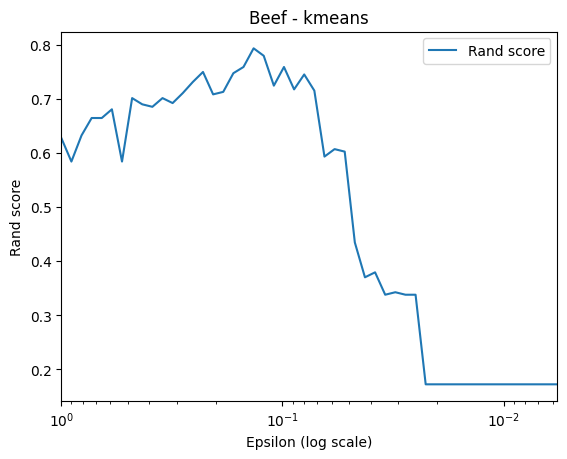

In [7]:
for dataset_name in output.keys():
    print(dataset_name)
    for method in output[dataset_name].keys():
        
        eps = output[dataset_name].get(method).get('eps')
        rands = output[dataset_name].get(method).get('rands')
        
        # Plotting in log scale
        plt.plot(eps, rands, label='Rand score')
        plt.xscale('log')  # Set x-axis to log scale
        plt.xlabel('Epsilon (log scale)')
        plt.ylabel('Rand score')
        plt.title(f'{dataset_name} - {method.__name__}')
        plt.xlim(eps[0], eps[-1])
        plt.legend()
        plt.show()
        break


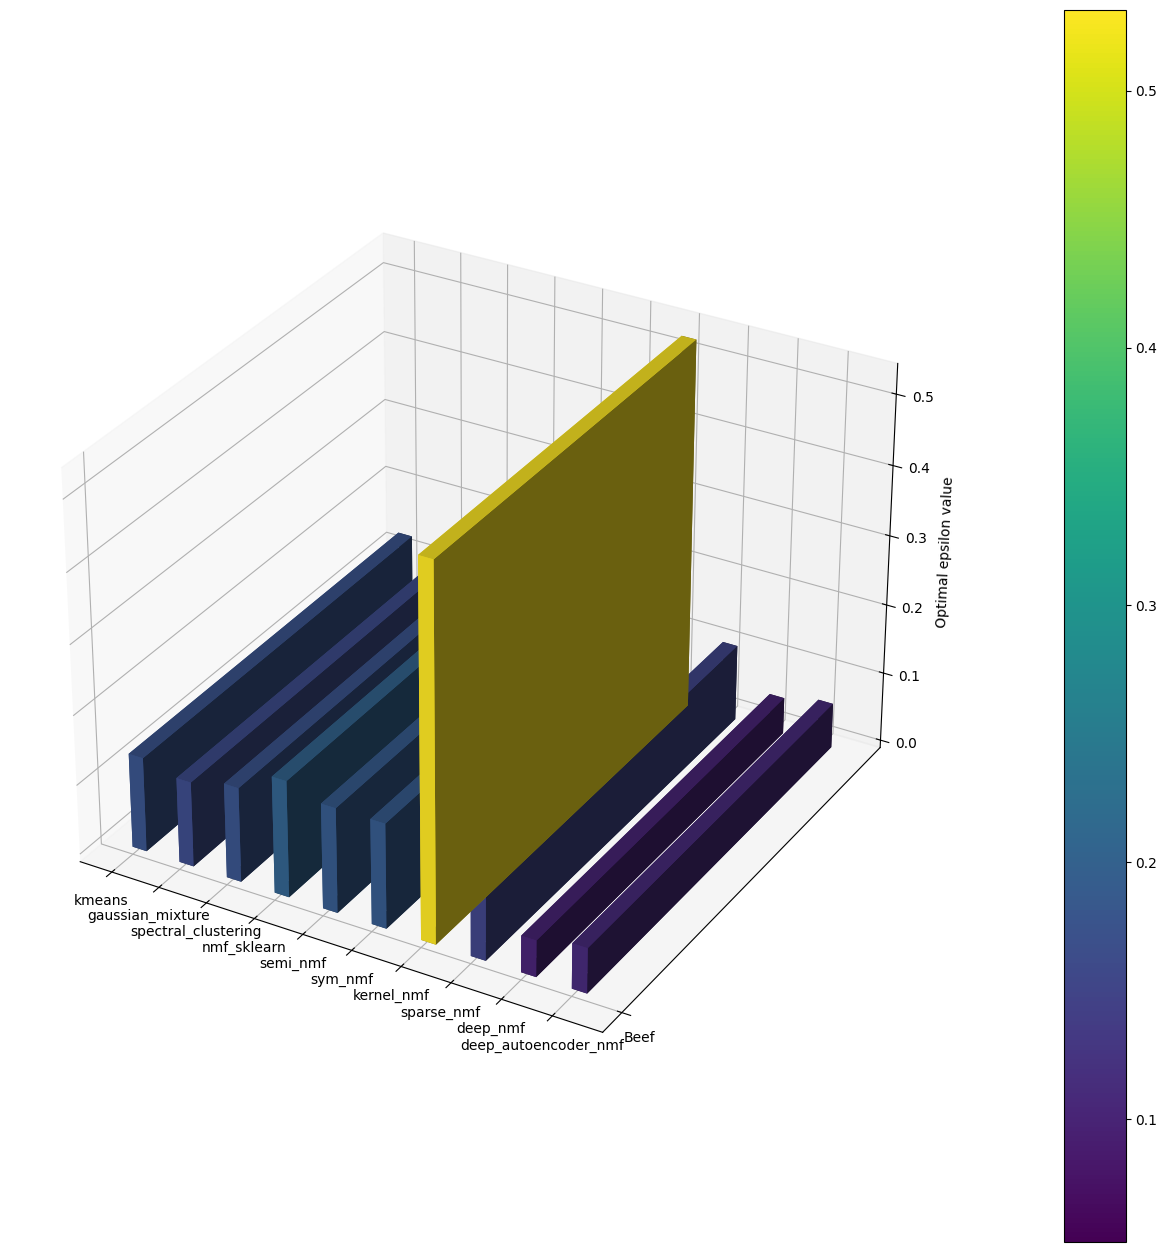

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

# Generate a 2D array (replace this with your own data)
#data = np.random.rand(5, 5) * 10
# Dummy dataset and method names
#dataset_names = ['Dataset A', 'Dataset B', 'Dataset C', 'Dataset D', 'Dataset E']
#method_names = ['Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5']

method_names = [method.__name__ for method in methods.keys()]
dataset_names = list(hyperparameters.keys())

data = np.array([[output[dataset_name][method]['best_epsilon'] for method in methods.keys()] for dataset_name in dataset_names])

# Create a meshgrid for x and y
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

# Flatten the arrays
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)

# Adjust the bar width and separation
bar_width = 0.3
bar_gap = 0.0

# Create a 3D plot
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D bars with color based on height
for xi, yi, zi, value in zip(x, y, z, data.flatten()):
    color = plt.cm.viridis(value / data.max())  # Use viridis colormap, adjust as needed
    ax.bar3d(xi, yi, zi, bar_width, bar_width, value, shade=True, color=color, zsort='average')

# Create a color scale along the z-axis
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(data.flatten())
cbar = plt.colorbar(mappable, ax=ax, pad=0.1)


# Customize x and y axis ticks and labels
ax.set_xticks(np.arange(len(method_names)))
ax.set_yticks(np.arange(len(dataset_names)))

ax.set_xticklabels(method_names)
ax.set_yticklabels(dataset_names)
# Set labels
#ax.set_xlabel('X-axis')
#ax.set_ylabel('Y-axis')
ax.set_zlabel('Optimal epsilon value')

# Show the plot
plt.show()
